# Data Picking and Classification on Smaller Datasets

This file is to try on training on a smaller dataset.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights, MobileNet_V3_Large_Weights, EfficientNet_B2_Weights, DenseNet121_Weights, MNASNet1_3_Weights, RegNet_X_1_6GF_Weights
from dataset import MultiLabelDataset
from tqdm import tqdm
from tools import get_data, load_data, remove_class
from torch.autograd import Variable
from typing import List, Tuple
from collections import Counter

In [2]:
# import data
train_data = get_data("./dataset/train.csv")
test_data = get_data("./dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

# join the data together
for_nlp_data = pd.concat((train_data['caption'], test_data['caption']), ignore_index=True)

In [3]:
print(f"Number of training instances: {train_data.shape[0]}")
print(f"Number of testing instances:  {test_data.shape[0]}")

Number of training instances: 30000
Number of testing instances:  10000


In [4]:
# get only class 2, 4 and 5
filtered_data = train_data[(train_data['class 2'] == 1) | (train_data['class 4'] == 1) | (train_data['class 5'] == 1)]

# remove other classes
classes_not_dropped = [2, 4, 5]
for i in range(train_data.shape[1] - 2):
	if ((i + 1) not in classes_not_dropped):
		filtered_data = filtered_data.drop(f'class {i + 1}', axis=1)

print(filtered_data)

        image_id                                            caption  class 2  \
6          6.jpg          a big airplane flying in the big blue sky      0.0   
7          7.jpg          a man riding a motor bike across a forest      0.0   
17        17.jpg               a small airplane that is on a runway      0.0   
40        40.jpg  man on dirt bike with a redheaded woman in his...      0.0   
41        41.jpg  people playing tennis on the court on a sunny day      1.0   
...          ...                                                ...      ...   
29960  29960.jpg  a motorcycle that is missing parts like a rear...      0.0   
29967  29967.jpg     a person on a bike rides next to a city street      1.0   
29971  29971.jpg  a group of people waiting to get off the ferry...      1.0   
29980  29980.jpg  airplane is docked at the airport so passenger...      0.0   
29995  29995.jpg  a picture of a truck that is in the middle of ...      1.0   

       class 4  class 5  
6          0.

## Image Classification Model

In [5]:
# define the image transformation: currently following resnet18
transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # converts images to [0, 1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [6]:
# initialize the dataset
train_dataset = MultiLabelDataset(
    csv_file=filtered_data,
    root_dir='./dataset/data/',
    vectorizer=None,
    transform=transform,
)

BATCH_SIZE=16

# load the dataset into batches 
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [7]:
# model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)
# model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# model = models.efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
# model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
# model = models.mnasnet1_3(weights=MNASNet1_3_Weights)
model = models.regnet_x_1_6gf(weights=RegNet_X_1_6GF_Weights.IMAGENET1K_V2)

# freeze the top layers of the model
for name, params in model.named_parameters():

    # MobileNet V3
    # if ("classifier" not in name):
    #     params.requires_grad = False

    # ResNet18
    # if ("fc" not in name):
    #     params.requires_grad = False

    # EfficentNet B2
    # if ("classifier" not in name):
    #     params.requires_grad = False
    
	# DenseNet 121
    # if ("classifier" not in name):
    #     params.requires_grad = False
    
	# MNASNet 1.3
    # if ("classifier" not in name):
    #     params.requires_grad = False
    
	# RegNet X 1 6GF
    if ("fc" not in name):
        params.requires_grad = False
    
# define the classifier layer again
n_out = 3

# MobileNet V3
# model.classifier = nn.Sequential(
#     nn.Linear(960, 1280),
#     nn.Hardswish(inplace=True),
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(1280, n_out),
# )

# ResNet18
# n_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(in_features=n_features, out_features=n_out),
# )

# EfficientNet B2
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(in_features=1408, out_features=n_out),
# )

# DenseNet 121
# model.classifier = nn.Sequential(
#     nn.Linear(in_features=1024, out_features=n_out),
# )

# # MNASNet 1.3
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(1280, n_out),
# )

# RegNet X 1 6GF
model.fc = nn.Sequential(
    nn.Linear(912, n_out),
)

# define hyperparameters
EPOCHS = 5
THRESHOLD = 0.5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


In [8]:
train_losses = []
train_accs = []
for epoch in range(EPOCHS):

	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for _, images, _, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			images = images.to('cuda')
			labels = labels.to('cuda')

		y_pred = model(images)

		# backward
		loss = loss_fn(y_pred, labels)
		loss.backward()

		# update
		optimizer.step()

		# compare
		predicted = (y_pred > THRESHOLD).int()

		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

		# if (n_total < 32):
		# 	print(train_loss)
		# 	print(n_correct)
		# 	print(n_total)
		# 	print(predicted)
		# 	print(labels)

	train_losses.append(train_loss / len(train_dataloader))
	train_accs.append(n_correct / n_total)

	print("Epoch {:d}, Train Loss: {:.7f}, Train Accuracy: {:.3f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))

Epoch 1 Training:   0%|          | 0/213 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/dataset.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 1 Training: 100%|██████████| 213/213 [00:14<00:00, 14.41it/s]


Epoch 1, Train Loss: 1.2114857, Train Accuracy: 35.954%


Epoch 2 Training: 100%|██████████| 213/213 [00:13<00:00, 15.77it/s]


Epoch 2, Train Loss: 2.4135093, Train Accuracy: 42.815%


Epoch 3 Training: 100%|██████████| 213/213 [00:13<00:00, 15.93it/s]


Epoch 3, Train Loss: 3.1528788, Train Accuracy: 51.472%


Epoch 4 Training: 100%|██████████| 213/213 [00:13<00:00, 15.95it/s]


Epoch 4, Train Loss: 3.4505545, Train Accuracy: 53.239%


Epoch 5 Training: 100%|██████████| 213/213 [00:13<00:00, 15.67it/s]

Epoch 5, Train Loss: 3.5991269, Train Accuracy: 59.688%


0.3595406413078308
0.4281507730484009
0.5147232413291931
0.5323910713195801
0.596878707408905


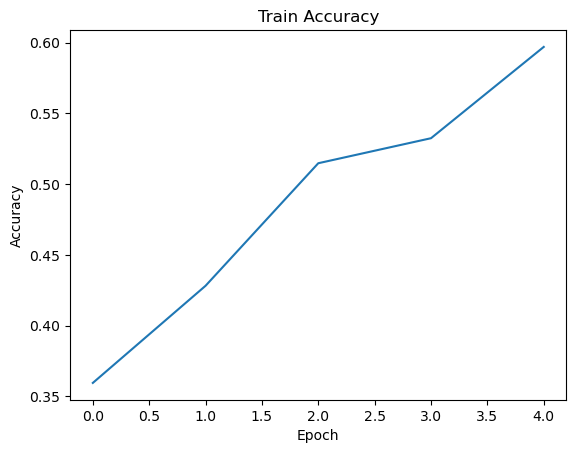

In [9]:
new_train_accs = []
for i, train_acc in enumerate(train_accs):
    new_train_accs.append(train_acc.item())
    print(train_acc.item())

plt.title("Train Accuracy")
plt.plot(new_train_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Text Classification Model

### Using Count Vectorizer

In [97]:
# Count Vectorizer
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(for_nlp_data)

X_train_vec = vectorizer.transform(filtered_data['caption'])
X_test_vec = vectorizer.transform(test_data['caption'])

# the size of vocabulary is 8075
print(X_train_vec.shape)
print(X_test_vec.shape)

(3396, 8075)
(10000, 8075)


In [98]:
X_train_tensor = torch.from_numpy(X_train_vec.todense()).int()
X_test_tensor = torch.from_numpy(X_test_vec.todense()).int()
y_train_tensor = torch.from_numpy(np.array(filtered_data.iloc[:, 2:]))
y_test_tensor = torch.from_numpy(np.array(test_data.iloc[:, 2:]))

### Instead of Count Vectorizer, Let's use Tokenization

Reference: [Sentiment Analysis using LSTM PyTorch](https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch)

In [99]:
def _preprocess_string(s: str) -> str:
	s = re.sub(r"[^\w\s]", '', s)
	s = re.sub(r"\s+", '', s)
	s = re.sub(r"\d", '', s)
	return s

def _padding(sentences: List[int], seq_len: int) -> np.ndarray:
	features = np.zeros((len(sentences), seq_len), dtype=int)
	for i, review in enumerate(sentences):
		if (len(review) != 0):
			features[i, -len(review):] = np.array(review)[:seq_len]
	return features

def tokenize(x_train: List[str], x_test: List[str]) -> Tuple[np.ndarray, np.ndarray, dict]:
	word_list = []	
	stop_words = set(stopwords.words('english'))
	for sentence in x_train:
		for word in sentence.lower().split():
			word = _preprocess_string(word)
			if word not in stop_words and word != '':
				word_list.append(word)

	corpus = Counter(word_list)
	corpus_ = sorted(corpus, key=corpus.get, reverse=True)
	onehot_dict = {w: i+1 for i,w in enumerate(corpus_)}

	# tokenize
	final_list_train = []
	for sentence in x_train:

		ls = []
		for word in sentence.lower().split():
			word = _preprocess_string(word)
			if (word in onehot_dict.keys()):
				idx = onehot_dict[word]
				ls.append(idx)
		final_list_train.append(ls)

	# find the maximum length of the sentence
	max_len = 0
	for sentence in final_list_train:
		max_len = len(sentence) if (len(sentence) > max_len) else max_len
	print(max_len)

	# padding
	final_list_train = _padding(final_list_train, max_len + 2)
	return final_list_train, None, onehot_dict

X_train_vec, X_test_vec, vocab = tokenize(filtered_data['caption'], None)
print(X_train_vec.shape)
print(len(vocab))

# to tensor
X_train_tensor = torch.from_numpy(X_train_vec).int()

16
(3396, 18)
2109


### Continue with Training

In [100]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16,
    shuffle=True
)

In [101]:
class LSTM(nn.Module):
    
	def __init__(self, no_layers: int, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int) -> None:
		super(LSTM, self).__init__()

		self.output_dim = output_dim
		self.hidden_dim = hidden_dim

		self.no_layers = no_layers
		self.vocab_size = vocab_size

		# embedding layer
		self.embedding_layer = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embedding_dim)

		# LSTM layer
		self.lstm_layer = nn.LSTM(
			input_size=embedding_dim, 
			hidden_size=hidden_dim, 
			num_layers=no_layers,
			batch_first=True,
		)

		# fully connected layer
		self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
		self.sig = nn.Sigmoid()

	def forward(self, x: torch.Tensor, hidden: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:

		batch_size = x.shape[0]

		# if hidden shape is not the same as expected due to batch size
		# average the others
		# target is the batch_size
		# we expect hidden state to have (no_layers, target, hidden_dim)
		device = 'cuda' if torch.cuda.is_available() else 'cpu'
		current_hidden_batch_size = hidden[0].shape[1]
		if (batch_size != current_hidden_batch_size):
			new_h = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
			new_c = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
			for i in range(self.no_layers):

				n = current_hidden_batch_size // batch_size
				for j in range(batch_size):

					temp_h = hidden[0][i, n*j:n*(j+1), :].float()
					temp_c = hidden[1][i, n*j:n*(j+1), :].float()
					if (j == batch_size - 1):
						temp_h = hidden[0][i, n*j:, :].float()
						temp_c = hidden[1][i, n*j:, :].float()

					mean_temp_h = torch.mean(temp_h, dim = 0)
					mean_temp_c = torch.mean(temp_c, dim = 0)

					new_h[i][j] = mean_temp_h
					new_c[i][j] = mean_temp_c
			hidden = (new_h, new_c)

		# embeddings and lstm_out
		embeds = self.embedding_layer(x) # shape: B x S x Feature since batch = True
		lstm_out, hidden = self.lstm_layer(embeds, hidden)

		lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

		# fully connected layer
		out = self.fc(lstm_out)
		out = self.sig(out)

		# reshape to be batch size first
		out = out.view(batch_size, -1)

		# get last batch of labels
		out = out[:, -3:]

		return out, hidden
	
	def init_hidden(self, batch_size: int):
		"""
		Initialize hidden state
		Create two new tensors with sizes n_layers x batch_size x hidden_dim,
		Initialized to zero, for hidden state and cell state of LSTM
		"""
		h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim))
		c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim))
		if (torch.cuda.is_available()):
			h0 = h0.to('cuda')
			c0 = c0.to('cuda')
		
		hidden = (h0, c0)
		return hidden

In [102]:
epochs = 50
threshold = 0.5

model = LSTM(
    no_layers=1,
    vocab_size=len(vocab), # extra 1 is already included, usually for padding
    embedding_dim=64,
    hidden_dim=256,
    output_dim=3,
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


In [103]:
clip = 5 # for exploding gradient problem
train_losses = []
train_accs = []
for epoch in range(epochs):

	# initialize the hidden state
	hidden = model.init_hidden(batch_size=BATCH_SIZE)

	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for captions, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			captions = captions.to('cuda')
			labels = labels.to('cuda')

		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		hidden = tuple([each.data for each in hidden])

		model.zero_grad()
		y_pred, hidden = model(captions, hidden)

		# backward
		loss = loss_fn(y_pred.squeeze(), labels)
		loss.backward()

		# clip_grad_norm helps prevent the exploding gradient problem in RNNs/LSTMs
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		# update
		optimizer.step()

		# compare
		predicted = (y_pred > threshold).int()
		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_loader))
	train_accs.append(n_correct / n_total)

	print("Epoch {:d}, Train Loss: {:.9f}, Train Accuracy: {:.7f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))

Epoch 1 Training: 100%|██████████| 213/213 [00:00<00:00, 300.74it/s]


Epoch 1, Train Loss: 0.697568439, Train Accuracy: 0.2355713%


Epoch 2 Training: 100%|██████████| 213/213 [00:00<00:00, 288.41it/s]


Epoch 2, Train Loss: 0.693163797, Train Accuracy: 0.0000000%


Epoch 3 Training: 100%|██████████| 213/213 [00:00<00:00, 327.46it/s]


Epoch 3, Train Loss: 0.693154547, Train Accuracy: 0.0000000%


Epoch 4 Training: 100%|██████████| 213/213 [00:00<00:00, 308.04it/s]


Epoch 4, Train Loss: 0.693150619, Train Accuracy: 0.0000000%


Epoch 5 Training: 100%|██████████| 213/213 [00:00<00:00, 387.34it/s]


Epoch 5, Train Loss: 0.693147783, Train Accuracy: 0.0000000%


Epoch 6 Training: 100%|██████████| 213/213 [00:00<00:00, 388.89it/s]


Epoch 6, Train Loss: 0.693147833, Train Accuracy: 0.0000000%


Epoch 7 Training: 100%|██████████| 213/213 [00:00<00:00, 498.61it/s]


Epoch 7, Train Loss: 0.693144070, Train Accuracy: 0.0000000%


Epoch 8 Training: 100%|██████████| 213/213 [00:00<00:00, 492.40it/s]


Epoch 8, Train Loss: 0.693141588, Train Accuracy: 0.0000000%


Epoch 9 Training: 100%|██████████| 213/213 [00:00<00:00, 480.95it/s]


Epoch 9, Train Loss: 0.652336219, Train Accuracy: 36.6607780%


Epoch 10 Training: 100%|██████████| 213/213 [00:00<00:00, 411.82it/s]


Epoch 10, Train Loss: 0.626938265, Train Accuracy: 52.2968216%


Epoch 11 Training: 100%|██████████| 213/213 [00:00<00:00, 325.88it/s]


Epoch 11, Train Loss: 0.606965084, Train Accuracy: 80.7714996%


Epoch 12 Training: 100%|██████████| 213/213 [00:00<00:00, 275.77it/s]


Epoch 12, Train Loss: 0.600342497, Train Accuracy: 82.2438202%


Epoch 13 Training: 100%|██████████| 213/213 [00:00<00:00, 288.49it/s]


Epoch 13, Train Loss: 0.596379576, Train Accuracy: 83.7750320%


Epoch 14 Training: 100%|██████████| 213/213 [00:00<00:00, 271.94it/s]


Epoch 14, Train Loss: 0.593389900, Train Accuracy: 84.3345184%


Epoch 15 Training: 100%|██████████| 213/213 [00:00<00:00, 259.81it/s]


Epoch 15, Train Loss: 0.590946607, Train Accuracy: 84.7762146%


Epoch 16 Training: 100%|██████████| 213/213 [00:00<00:00, 416.26it/s]


Epoch 16, Train Loss: 0.587912451, Train Accuracy: 85.7184982%


Epoch 17 Training: 100%|██████████| 213/213 [00:00<00:00, 255.25it/s]


Epoch 17, Train Loss: 0.585800983, Train Accuracy: 86.9257965%


Epoch 18 Training: 100%|██████████| 213/213 [00:00<00:00, 461.59it/s]


Epoch 18, Train Loss: 0.582732614, Train Accuracy: 88.3097839%


Epoch 19 Training: 100%|██████████| 213/213 [00:00<00:00, 259.93it/s]


Epoch 19, Train Loss: 0.581030915, Train Accuracy: 89.0459442%


Epoch 20 Training: 100%|██████████| 213/213 [00:00<00:00, 360.67it/s]


Epoch 20, Train Loss: 0.579475396, Train Accuracy: 89.8998871%


Epoch 21 Training: 100%|██████████| 213/213 [00:00<00:00, 413.97it/s]


Epoch 21, Train Loss: 0.578762273, Train Accuracy: 90.2237930%


Epoch 22 Training: 100%|██████████| 213/213 [00:00<00:00, 307.01it/s]


Epoch 22, Train Loss: 0.577703437, Train Accuracy: 90.6360474%


Epoch 23 Training: 100%|██████████| 213/213 [00:00<00:00, 278.44it/s]


Epoch 23, Train Loss: 0.577095352, Train Accuracy: 91.2249756%


Epoch 24 Training: 100%|██████████| 213/213 [00:00<00:00, 387.04it/s]


Epoch 24, Train Loss: 0.575930457, Train Accuracy: 91.5783310%


Epoch 25 Training: 100%|██████████| 213/213 [00:00<00:00, 472.53it/s]


Epoch 25, Train Loss: 0.576495115, Train Accuracy: 91.5488815%


Epoch 26 Training: 100%|██████████| 213/213 [00:00<00:00, 478.99it/s]


Epoch 26, Train Loss: 0.574816254, Train Accuracy: 92.3144913%


Epoch 27 Training: 100%|██████████| 213/213 [00:00<00:00, 486.30it/s]


Epoch 27, Train Loss: 0.574872129, Train Accuracy: 92.0789185%


Epoch 28 Training: 100%|██████████| 213/213 [00:00<00:00, 450.65it/s]


Epoch 28, Train Loss: 0.574965860, Train Accuracy: 92.3144913%


Epoch 29 Training: 100%|██████████| 213/213 [00:00<00:00, 473.75it/s]


Epoch 29, Train Loss: 0.573553204, Train Accuracy: 92.9623108%


Epoch 30 Training: 100%|██████████| 213/213 [00:00<00:00, 344.19it/s]


Epoch 30, Train Loss: 0.572714626, Train Accuracy: 93.2273331%


Epoch 31 Training: 100%|██████████| 213/213 [00:00<00:00, 433.99it/s]


Epoch 31, Train Loss: 0.572953657, Train Accuracy: 93.0801010%


Epoch 32 Training: 100%|██████████| 213/213 [00:00<00:00, 465.72it/s]


Epoch 32, Train Loss: 0.571927391, Train Accuracy: 93.4923477%


Epoch 33 Training: 100%|██████████| 213/213 [00:00<00:00, 477.86it/s]


Epoch 33, Train Loss: 0.571617676, Train Accuracy: 93.7573700%


Epoch 34 Training: 100%|██████████| 213/213 [00:00<00:00, 472.04it/s]


Epoch 34, Train Loss: 0.571537872, Train Accuracy: 93.6984711%


Epoch 35 Training: 100%|██████████| 213/213 [00:00<00:00, 499.04it/s]


Epoch 35, Train Loss: 0.571236777, Train Accuracy: 93.9045944%


Epoch 36 Training: 100%|██████████| 213/213 [00:00<00:00, 490.60it/s]


Epoch 36, Train Loss: 0.570995285, Train Accuracy: 94.0223846%


Epoch 37 Training: 100%|██████████| 213/213 [00:00<00:00, 480.07it/s]


Epoch 37, Train Loss: 0.571455057, Train Accuracy: 94.0812759%


Epoch 38 Training: 100%|██████████| 213/213 [00:00<00:00, 292.06it/s]


Epoch 38, Train Loss: 0.570760915, Train Accuracy: 94.1401672%


Epoch 39 Training: 100%|██████████| 213/213 [00:00<00:00, 358.07it/s]


Epoch 39, Train Loss: 0.571069469, Train Accuracy: 93.9045944%


Epoch 40 Training: 100%|██████████| 213/213 [00:00<00:00, 309.56it/s]


Epoch 40, Train Loss: 0.570805765, Train Accuracy: 94.2579575%


Epoch 41 Training: 100%|██████████| 213/213 [00:00<00:00, 478.17it/s]


Epoch 41, Train Loss: 0.570949702, Train Accuracy: 94.1401672%


Epoch 42 Training: 100%|██████████| 213/213 [00:00<00:00, 493.59it/s]


Epoch 42, Train Loss: 0.570550006, Train Accuracy: 94.3168488%


Epoch 43 Training: 100%|██████████| 213/213 [00:00<00:00, 470.76it/s]


Epoch 43, Train Loss: 0.570119425, Train Accuracy: 94.4640808%


Epoch 44 Training: 100%|██████████| 213/213 [00:00<00:00, 327.73it/s]


Epoch 44, Train Loss: 0.569812651, Train Accuracy: 94.5818634%


Epoch 45 Training: 100%|██████████| 213/213 [00:00<00:00, 443.04it/s]


Epoch 45, Train Loss: 0.569868559, Train Accuracy: 94.5818634%


Epoch 46 Training: 100%|██████████| 213/213 [00:00<00:00, 366.83it/s]


Epoch 46, Train Loss: 0.570198694, Train Accuracy: 94.5524139%


Epoch 47 Training: 100%|██████████| 213/213 [00:00<00:00, 315.11it/s]


Epoch 47, Train Loss: 0.570299880, Train Accuracy: 94.4640808%


Epoch 48 Training: 100%|██████████| 213/213 [00:00<00:00, 471.00it/s]


Epoch 48, Train Loss: 0.570502501, Train Accuracy: 94.4346313%


Epoch 49 Training: 100%|██████████| 213/213 [00:00<00:00, 494.55it/s]


Epoch 49, Train Loss: 0.570346098, Train Accuracy: 94.4051895%


Epoch 50 Training: 100%|██████████| 213/213 [00:00<00:00, 317.80it/s]

Epoch 50, Train Loss: 0.569506156, Train Accuracy: 94.7585373%


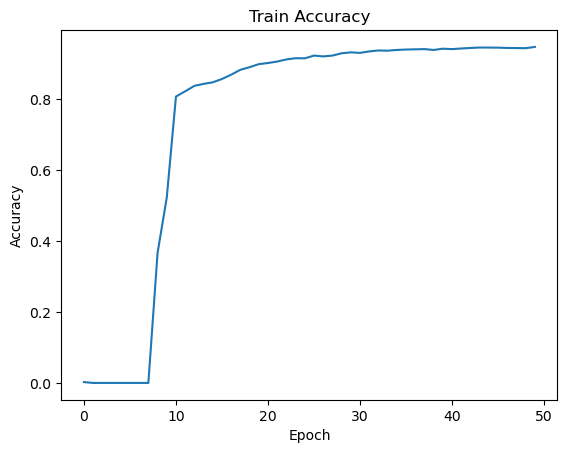

In [104]:
new_train_accs = []
for i, train_acc in enumerate(train_accs):
    new_train_accs.append(train_acc.item())
    # print(train_acc.item())

plt.title("Train Accuracy")
plt.plot(new_train_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Combined Model